In [1]:
import pickle
import numpy as np
import re
from utils import clean, split_on_caps, TOP_100_PLAYERS
import pandas as pd
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import nltk
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel
from gensim import corpora

STOPLIST = stopwords.words('english')

import codecs
import json

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

from matplotlib import pyplot as plt

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

## Load Data

In [7]:
docs_cleaned_filename = "docs_cleaned_saturday"
with open (docs_cleaned_filename, 'rb') as fp:
    docs = pickle.load(fp)
    
article_dicts_filename = "article_dicts_saturday"
all_articles = []
with codecs.open(article_dicts_filename,'rU','utf-8') as f:
    for line in f:
        all_articles.append(json.loads(line))

### Get only alphabetical, and lemmatize

In [8]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return [ps.stem(item) for item in tokens]

In [9]:
lemmatized = [" ".join(tokenize(text)) for text in docs]

### LDA on all the documents

#### Use TF-IDF to identify screen most important words

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_screener = TfidfVectorizer(stop_words = 'english', min_df = 0.01, max_df = 0.23)

trans = tfidf_screener.fit_transform(lemmatized)
feats = tfidf_screener.get_feature_names()
vocab = set(tfidf_screener.vocabulary_.keys())

In [51]:
texts = [" ".join([word for word in text.split() if word in vocab]) for text in lemmatized]
vectorizer = CountVectorizer(analyzer='word', lowercase=True)
data_vectorized = vectorizer.fit_transform(texts)

In [12]:
%%time
# Build LDA Model
NUM_TOPICS = 30
lda_model = LatentDirichletAllocation(n_topics=NUM_TOPICS,       # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

# print(lda_model)  # Model attributes

/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


CPU times: user 2.47 s, sys: 1 s, total: 3.47 s
Wall time: 27 s


## Diagnose model performance with perplexity and log-likelihood

In [13]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
# pprint(lda_model.get_params())

Log Likelihood:  -5284795.145029623
Perplexity:  1155.66406655568


## Grid Search for Best LDA Model

In [59]:
# Define Search Param
search_params = {'n_components': [10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### See Best

In [68]:
# Best Model
# best_lda_model = model.best_estimator_
best_lda_model = LatentDirichletAllocation(n_topics=15, learning_decay=0.5)
best_lda_model.fit(data_vectorized)

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -1607965.3711583856
Model Perplexity:  1252.8889234097117


### Compare LDA Model Performance Scores

/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


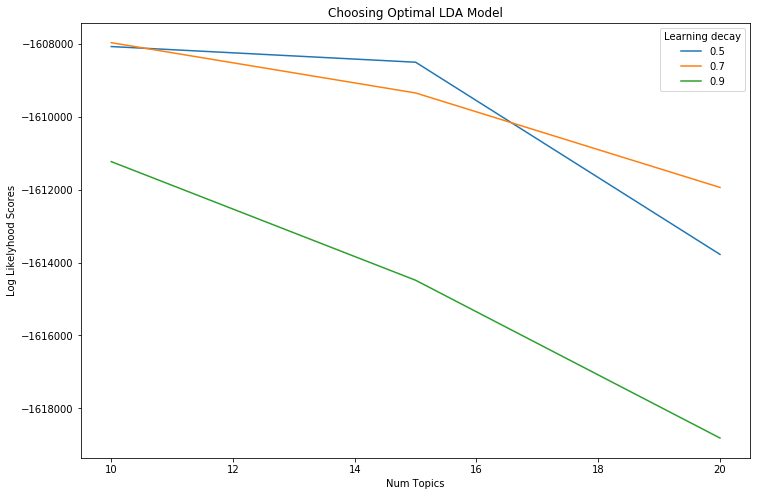

In [62]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## See Dominant Topic in Each Document

In [63]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
best_n_topics = 10
topicnames = ["Topic" + str(i) for i in range(best_n_topics)]

# topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0.39,0,0,0,0,0,0.54,0,0.07,7
Doc1,0,0.36,0.11,0,0,0,0.03,0.42,0,0.08,7
Doc2,0,0.23,0.18,0,0,0.1,0,0.43,0.06,0,7
Doc3,0,0.12,0.24,0,0,0,0,0.6,0.04,0,7
Doc4,0,0.12,0.24,0,0,0,0,0.6,0.04,0,7
Doc5,0,0.58,0.07,0,0,0,0,0.28,0,0.07,1
Doc6,0,0.19,0.23,0,0.07,0,0,0.51,0,0,7
Doc7,0,0.34,0,0,0.07,0,0,0.45,0.03,0.11,7
Doc8,0,0.19,0.23,0,0.07,0,0,0.51,0,0,7
Doc9,0.14,0.73,0,0,0,0,0,0.13,0,0,1


## Review Topic Distribution across Documents

In [64]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,508
1,5,488
2,7,467
3,0,384
4,4,358
5,3,333
6,9,313
7,2,198
8,8,196
9,6,69


## Visualize the LDA Model with pyLDAvis

In [69]:
# !pip install pyLDAvis
import pyLDAvis
from pyLDAvis import sklearn as sk

In [70]:
pyLDAvis.enable_notebook()
panel = sk.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
14     14.232418        1       1  -73.851791  -56.390167
5      14.226630        1       2  140.737671  -91.520470
4      10.728824        1       3  150.907486   10.943673
13      9.979922        1       4 -106.617256 -144.348892
6       7.752657        1       5   31.703785 -186.458527
0       7.177930        1       6  -28.760399  108.179947
2       6.791070        1       7   28.413424   42.127182
3       6.535524        1       8    3.454533  -42.780861
10      6.193957        1       9 -152.919891  -42.810249
11      5.491324        1      10   92.028267   91.735504
1       4.332725        1      11  -46.328831   19.755114
7       1.964256        1      12   58.960049 -104.590263
9       1.649443        1      13 -120.178329   51.296757
12      1.593799        1      14  -24.391462 -122.077957
8       1.349521        1      15   77.118927  -21.421648, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
2712  Default  1592.000000        warrior  1592.000000  30.0000  30.0000
1643  Default  1020.000000            nfl  1020.000000  29.0000  29.0000
1575  Default  1278.000000             mj  1278.000000  28.0000  28.0000
1558  Default  1634.000000        million  1634.000000  27.0000  27.0000
373   Default  1210.000000         celtic  1210.000000  26.0000  26.0000
2560  Default  1274.000000     tournament  1274.000000  25.0000  25.0000
2162  Default  1576.000000           seed  1576.000000  24.0000  24.0000
2354  Default  1935.000000          state  1935.000000  23.0000  23.0000
1331  Default   704.000000          knick   704.000000  22.0000  22.0000
1639  Default   780.000000       new_york   780.000000  21.0000  21.0000
2335  Default  1051.000000           spur  1051.000000  20.0000  20.0000
2366  Default  1054.000000  stephen_curri  1054.000000  19.0000  19.0000
1379  Default  2417.000000     lebron_jam  2417.000000  18.0000  18.0000
2642  Default   764.000000           unit   764.000000  17.0000  17.0000
307   Default   945.000000          brown   945.000000  16.0000  16.0000
269   Default  1134.000000         boston  1134.000000  15.0000  15.0000
1811  Default  1377.000000   philadelphia  1377.000000  14.0000  14.0000
1526  Default   872.000000           meek   872.000000  13.0000  13.0000
948   Default   718.000000        footbal   718.000000  12.0000  12.0000
2248  Default  1144.000000          sixer  1144.000000  11.0000  11.0000
423   Default   819.000000           citi   819.000000  10.0000  10.0000
2513  Default   661.000000        thunder   661.000000   9.0000   9.0000
1265  Default   971.000000         jersey   971.000000   8.0000   8.0000
1999  Default   792.000000   recordcollin   792.000000   7.0000   7.0000
600   Default  1668.000000           deal  1668.000000   6.0000   6.0000
231   Default   589.000000            bet   589.000000   5.0000   5.0000
2732  Default   928.000000         welcom   928.000000   4.0000   4.0000
1275  Default   890.000000    joel_embiid   890.000000   3.0000   3.0000
1626  Default   872.000000           ncaa   872.000000   2.0000   2.0000
2145  Default   957.000000         school   957.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
1800  Topic15    68.645232          perri    69.612297   4.2914  -4.8353
217   Topic15    64.886598         begley    65.853666   4.2906  -4.8916
228   Topic15    51.606211         berman    52.573277   4.2869  -5.1206
1080  Topic15    79.320399       hardaway    84.963219   4.2367  -4.6907
788   Topic15    44.040285            ene    49.552118   4.1875  -5.2791
2766  Topic15   301.871717           wnba   343.738141   4.1755  -3.3542
1120  Topic15   175.159524           hire   223.275967   4.0627  -3.8985
325   Topic15    68.821600           burk   101.869

### See Topic's Keywords

In [48]:
topicnames = ["Topic" + str(i) for i in range(lda_model.n_topics)]

In [49]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaron,abc,abilities,ability,able,absence,absolutely,absurd,abysmal,academy,...,younger,youngmisuk,youngsters,youth,youtube,zach,zaza,zero,zhaire,zone
Topic0,0.033343,0.033343,0.033344,0.033347,0.033343,0.033346,0.033342,0.033347,0.033344,0.033343,...,0.033343,0.033343,0.033343,0.033343,0.033342,0.033342,0.033344,0.033342,0.033346,0.033343
Topic1,0.033345,0.033344,0.033343,0.033344,0.033343,0.033343,0.033344,0.033343,0.033345,0.033343,...,0.033344,0.033343,0.033344,0.033342,0.033342,0.033344,0.033343,0.033343,0.033344,0.033344
Topic2,0.033349,0.033344,0.033347,0.033350,0.033345,0.033345,0.033344,0.033344,0.033342,0.033345,...,0.033345,0.033343,0.033344,0.033343,0.033343,0.033347,0.033342,0.033342,0.033356,0.033344
Topic3,0.033343,0.033346,0.033347,0.033347,0.033346,0.033347,0.033342,0.033346,0.033341,0.033343,...,0.033344,0.033342,0.033344,0.033345,0.033346,0.033346,0.033344,0.033347,0.033348,0.033343
Topic4,0.033342,0.033345,0.033342,0.033341,0.033343,0.033343,0.033344,0.033343,0.033343,0.033343,...,0.033343,0.033342,0.033344,0.033344,0.033342,0.033343,0.033345,0.033343,0.033343,0.033344


### Get 15 top keywords for each topic

In [58]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

NameError: name 'best_lda_model' is not defined

## Predict New Topics for New Piece of Text

In [ ]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

### Cluster Documents that share Similar Topics and Plot

In [ ]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

### Plot the Two SVD Components

In [ ]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [ ]:
## Get similar Documents
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)


# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

In [23]:
# texts = [[word for word in text.split() if word in vocab and word.isalpha()] for text in docs] # not tokenizing for now
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# %%time
# NUM_TOPICS = 30
# lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, update_every=1, chunksize=5000, passes=4)

CPU times: user 32 s, sys: 1.09 s, total: 33.1 s
Wall time: 33.4 s


In [117]:
# for i in range(NUM_TOPICS):
#     for word_id, p in lda.get_topic_terms(i):
#         print(dictionary[word_id],p, end=" ")
#     print("\n")

In [81]:
# for word_id, prob in lda.get_topic_terms(3)[:5]:
#     print(dictionary[word_id], prob, end=" ")
# print("\n")

million 0.024970928 trade 0.02018343 pick 0.016988372 free 0.014145047 deal 0.011659104 



In [94]:
# from collections import defaultdict
# topic2docs = defaultdict(list)
# for i,corpus_doc in enumerate(corpus):
#     topic_id = max(lda[corpus_doc], key=lambda x:x[1])[0]
#     topic2docs[topic_id].append(i)